In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install git+https://github.com/omarcastano/MasterThesis.git

In [3]:
#!cp -r '/content/drive/MyDrive/Maestria/Datasets/LabelsGeoTiffv2.7z' /content
#!7z x "/content/LabelsGeoTiffv2.7z"
#!cp -r '/content/drive/MyDrive/Maestria/Datasets/Dataset.7z' /content
#!7z x "/content/Dataset.7z"

In [4]:
from MasterThesis.segmentation.dataset import CustomDataset
from MasterThesis import EDA
import pandas as pd

from MasterThesis.segmentation.dataset import CustomDataset
from MasterThesis.segmentation.utils import visualize_augmented_images
from MasterThesis.classification.utils import generate_metadata_train_test_stratified_cv
from MasterThesis.trainer import Trainer

import torch

import wandb
wandb.login(key="3dfb06e1099f6465f340f29f3fbd268fac8216e2")

True

In [5]:
drive_path = "/media/omar/storage/gdrive/"
#drive_path = '/content/drive/MyDrive/'

In [6]:
path_to_labels = f"{drive_path}Maestria/Datasets/LabelsGeoTiffv2/"  # "/content/LabelsGeoTiffv2/" #
path_to_images = f"{drive_path}Maestria/Datasets/Dataset/"  # "/content/Dataset/" #
select_classes = [
    "non_agricultural_area",
    "agricultural_frontier",
]  # ["non_agricultural_area", "legal_exclusions", "agricultural_frontier"]

In [7]:
query = ["((legal_exclusions == 0) and ((non_agricultural == 1) or (agricultural_frontier == 1))) "]
# "| ((legal_exclusions == 1) and (non_agricultural == 0) and (agricultural_frontier == 0))"]

In [8]:
# Load metadata
path_to_metadata = f"{drive_path}Maestria/Datasets/metadata.csv"
metadata = pd.read_csv(path_to_metadata).sample(frac=0.25, random_state=42)
metadata["Labels"] = (metadata["non_agricultural(km2)"] <= 0.5)*1
metadata = metadata.query(query[0])

print(metadata.shape)
metadata.head()

(11899, 11)


,Id,Elevation,Image,Mask,non_agricultural(km2),agricultural_frontier(km2),legal_exclusions(km2),non_agricultural,legal_exclusions,agricultural_frontier,Labels
27030,181810200900132113,"18NVN/18NVN_1_0/(200, 900)/elevation.tif","18NVN/18NVN_1_0/(200, 900)/chip.npy","18NVN/18NVN_1_0/(200, 900)/mask.tif",0.062,0.938,0.0,1,0,1,1
23748,181851400700132112,"18NVM/18NVM_5_1/(400, 700)/elevation.tif","18NVM/18NVM_5_1/(400, 700)/chip.npy","18NVM/18NVM_5_1/(400, 700)/mask.tif",0.504,0.496,0.0,1,0,1,0
11740,181828300900132015,"18NUP/18NUP_2_8/(300, 900)/elevation.tif","18NUP/18NUP_2_8/(300, 900)/chip.npy","18NUP/18NUP_2_8/(300, 900)/mask.tif",0.000,1.000,0.0,0,0,1,1
4543,181894400300132012,"18NUM/18NUM_9_4/(400, 300)/elevation.tif","18NUM/18NUM_9_4/(400, 300)/chip.npy","18NUM/18NUM_9_4/(400, 300)/mask.tif",0.034,0.966,0.0,1,0,1,1
4657,181896500700132012,"18NUM/18NUM_9_6/(500, 700)/elevation.tif","18NUM/18NUM_9_6/(500, 700)/chip.npy","18NUM/18NUM_9_6/(500, 700)/mask.tif",0.191,0.809,0.0,1,0,1,1


In [9]:
select_classes

['non_agricultural_area', 'agricultural_frontier']

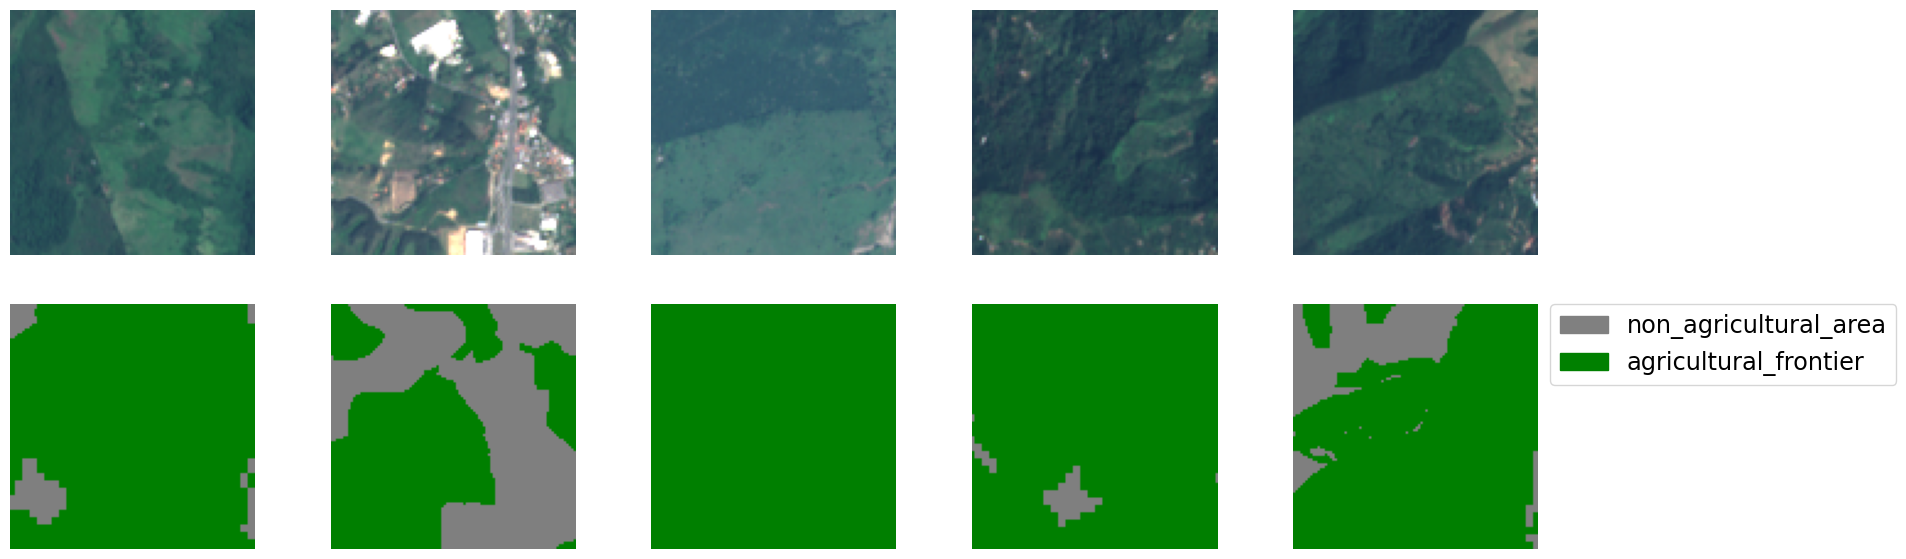

In [10]:
# Plot images
cmap = {0: [0.5, 0.5, 0.5, 1], 1: [0.0, 0.5, 0.0, 1]}

fig = EDA.visualize_images_and_masks(
    path_to_labels, path_to_images, metadata, n=5, figsize=(20, 7), class_names=select_classes, cmap=cmap
)

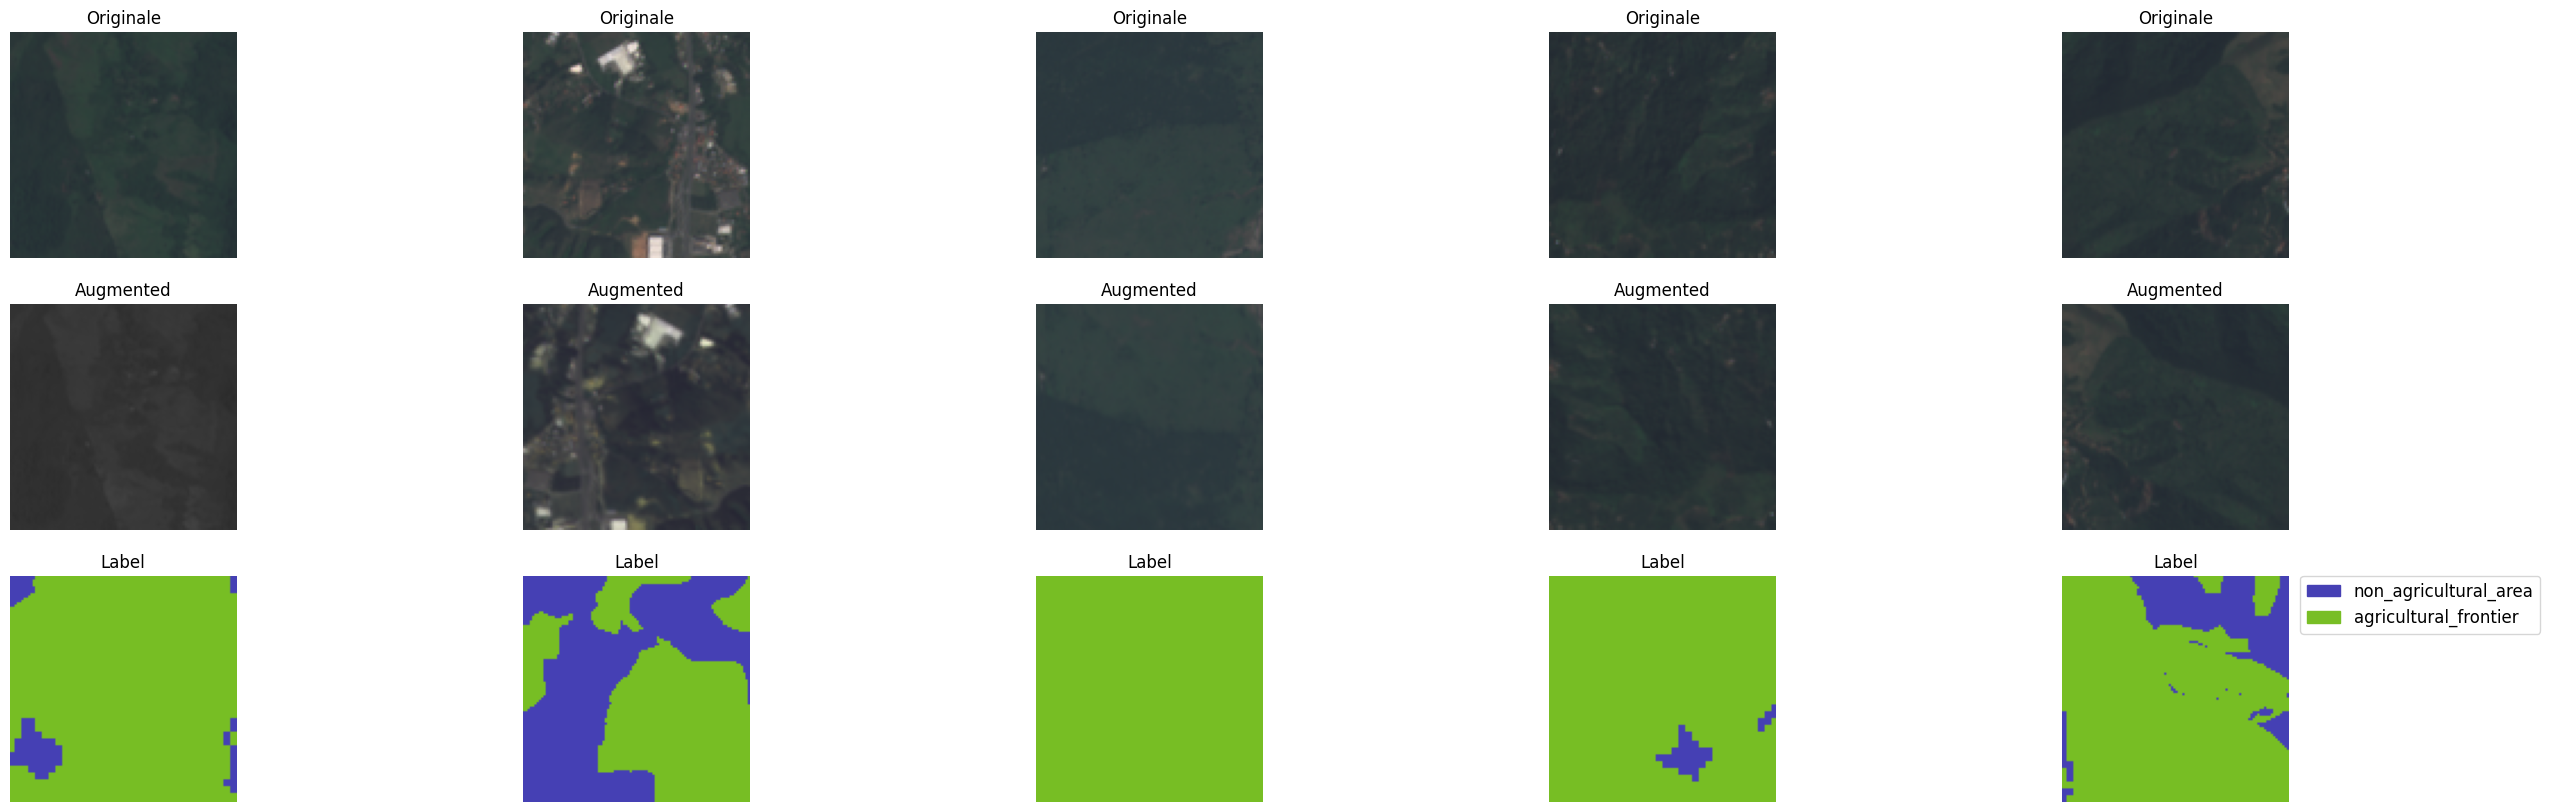

In [11]:
augment = {
    "horizontal_flip_prob": 0.5,
    "vertical_flip_prob": 0.5,
    "resize_scale": (0.8, 1.0),
    "resize_prob": 0.5,
    "brightness": 0.1,
    "contrast": 0.1,
    "saturation": 0.1,
    "hue": 0.1,
    "color_jitter_prob": 0.5,
    "gray_scale_prob": 0.2,
}

ds = CustomDataset(path_to_images, path_to_labels, metadata, return_original=True, augment=augment)
visualize_augmented_images(ds, classes_name=select_classes, n=5)

In [12]:
augment = {
    "horizontal_flip_prob": 0.5,
    "vertical_flip_prob": 0.5,
    "resize_scale": (0.8, 1.0),
    "resize_prob": 0.0,
    "brightness": 0.1,
    "contrast": 0.1,
    "saturation": 0.1,
    "hue": 0.1,
    "color_jitter_prob": 0.2,
    "gray_scale_prob": 0.2,
}

In [13]:
metadata_train, metadata_test, metadata_valid = generate_metadata_train_test_stratified_cv(metadata, train_size=10, n_split=4)

Number fo total images : 11899
Number of images to train: 10, 0.084%
Number of images to test: 2975, 25.002000000000002%
Number of images to valid: 2975, 25.002000000000002%


In [14]:
def run_experiment(
    train_size,
    epochs,
    pretrained=False,
    version="RandomInit",
    path_to_load_backbone=None,
    fine_tune=False,
    ft_epoch=30,
    project="CLF-2_classes",
    train_batch_size=8,
):
    metadata_train, metadata_test, metadata_valid = generate_metadata_train_test_stratified_cv(metadata, train_size=train_size, n_split=5)

    hypm_kwargs = {
        "version": version,
        "model_name": "Unet",
        "amount_of_ft_data": metadata_train[1].shape[0],
        "backbone": "resnet18",
        "pretrained": pretrained,
        "fine_tune": fine_tune,
        "ft_epoch": ft_epoch,
        "ft_lr": 0.000005,
        "in_channels": 3,
        "num_classes": 2,
        "class_names": select_classes,
        "normalizing_factor": 6000,
        "weight_decay": 0.00005,
        "learning_rate": 1e-3,
        "train_batch_size": train_batch_size,
        "test_batch_size": 256,
        "epochs": epochs,
        "augment_train": augment,
        "augment_test": None,
        "patient": 15,
        "eval_epoch": 1,
    }

    wandb_kwargs = {
        "project": "Segmentation-2_classes",
        "entity": "omar-c",
        "id": None,
        "name": version,
        "resume": False,
    }

    for train, test, valid in zip(metadata_train, metadata_test, metadata_valid):
        metadata_kwargs = {
            "path_to_images": path_to_images,
            "path_to_labels": path_to_labels,
            "path_to_save_model": None,  # path_to_save_model,  # Path to save the model that is being trained (do not include the extension .pt or .pth)
            "path_to_load_model": None,  # Path to load a model from a checkpoint (useful to handle notebook disconection)
            "path_to_load_backbone": path_to_load_backbone,
            "metadata_train": train,
            "metadata_test": test,
            "metadata_valid": valid,
            "num_workers": 6,
            "device": "cuda",
        }

        trainer = Trainer(CustomDataset, visualize_augmented_images, wandb_kwargs, hypm_kwargs, metadata_kwargs)
        trainer.configure_trainer()

        trainer.fit()

        break

    torch.save(trainer.model, f"models/model_{train_size}_{version}.pth")

In [15]:
path_to_save_model = f"{drive_path}Maestria/pruebas/models/resnet18"
path_to_load_backbone_glcnet = f"{drive_path}Maestria/Theses/SSL/GLCNet/models/resnet18/model_Eleve-GLCNet(a=0.0).pth"
# path_to_load_backbone_elevation_simclr = f"{drive_path}Maestria/Theses/SSL/ElevationSSL/models/resnet18/Elevation-SimCLR/model_SimCLR-Elevation.pth"
# path_to_load_backbone_elevation = f"{drive_path}Maestria/Theses/SSL/ElevationSSL/models/resnet18/Elevation/model_Elevation.pth"

In [16]:
run_experiment(
    train_size=80,
    epochs=100,
    pretrained=False,
    version="RandomInit",
    path_to_load_backbone=None,
    fine_tune=False,
    ft_epoch=None,
    train_batch_size=5,
)

run_experiment(
    train_size=80,
    epochs=100,
    pretrained=True,
    version="SimCLR",
    path_to_load_backbone=path_to_load_backbone_glcnet,
    fine_tune=True,
    ft_epoch=10,
    train_batch_size=5,
)

    # run_experiment(
    #     train_size=i,
    #     epochs=100,
    #     pretrained=True,
    #     version="Elevation+SimCLR",
    #     path_to_load_backbone=path_to_load_backbone_elevation_simclr,
    #     fine_tune=True,
    #     ft_epoch=10,
    #     train_batch_size=5,
    # )

    # run_experiment(
    #     train_size=i,
    #     epochs=100,
    #     pretrained=True,
    #     version="Elevation",
    #     path_to_load_backbone=path_to_load_backbone_elevation,
    #     fine_tune=True,
    #     ft_epoch=10,
    #     train_batch_size=5,
    # )

Number fo total images : 11899
Number of images to train: 80, 0.672%
Number of images to test: 2380, 20.002%
Number of images to valid: 2380, 20.002%
--------------------
run_id 5qf4q5k7
--------------------


Epoch 1/100 :   0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'path_to_load_backbone_simclr' is not defined

In [ ]:
# for i in [10, 20, 40, 80]:

#     run_experiment(
#         train_size=i,
#         epochs=100,
#         pretrained=False,
#         version="RandomInit",
#         path_to_load_backbone=None,
#         fine_tune=False,
#         ft_epoch=None,
#         train_batch_size=5,
#     )

#     run_experiment(
#         train_size=i,
#         epochs=100,
#         pretrained=True,
#         version="SimCLR",
#         path_to_load_backbone=path_to_load_backbone_simclr,
#         fine_tune=True,
#         ft_epoch=10,
#         train_batch_size=5,
#     )

#     run_experiment(
#         train_size=i,
#         epochs=100,
#         pretrained=True,
#         version="Elevation+SimCLR",
#         path_to_load_backbone=path_to_load_backbone_elevation_simclr,
#         fine_tune=True,
#         ft_epoch=10,
#         train_batch_size=5,
#     )

#     run_experiment(
#         train_size=i,
#         epochs=100,
#         pretrained=True,
#         version="Elevation",
#         path_to_load_backbone=path_to_load_backbone_elevation,
#         fine_tune=True,
#         ft_epoch=10,
#         train_batch_size=5,
#     )

In [ ]:
# for i in [100, 200, 500]:

#     run_experiment(
#         train_size=i,
#         epochs=100,
#         pretrained=False,
#         version="RandomInit",
#         path_to_load_backbone=None,
#         fine_tune=False,
#         ft_epoch=None,
#         train_batch_size=16,
#     )

#     run_experiment(
#         train_size=i,
#         epochs=100,
#         pretrained=True,
#         version="SimCLR",
#         path_to_load_backbone=path_to_load_backbone_simclr,
#         fine_tune=True,
#         ft_epoch=10,
#         train_batch_size=16,
#     )

#     run_experiment(
#         train_size=i,
#         epochs=100,
#         pretrained=True,
#         version="Elevation+SimCLR",
#         path_to_load_backbone=path_to_load_backbone_elevation_simclr,
#         fine_tune=True,
#         ft_epoch=10,
#         train_batch_size=16,
#     )

#     run_experiment(
#         train_size=i,
#         epochs=100,
#         pretrained=True,
#         version="Elevation",
#         path_to_load_backbone=path_to_load_backbone_elevation,
#         fine_tune=True,
#         ft_epoch=10,
#         train_batch_size=16,
#     )

In [ ]:
# for i in [1000, 2000, 3000]:

#     run_experiment(
#         train_size=i,
#         epochs=150,
#         pretrained=False,
#         version="RandomInit",
#         path_to_load_backbone=None,
#         fine_tune=False,
#         ft_epoch=None,
#         train_batch_size=32,
#     )

#     run_experiment(
#         train_size=i,
#         epochs=150,
#         pretrained=True,
#         version="SimCLR",
#         path_to_load_backbone=path_to_load_backbone_simclr,
#         fine_tune=True,
#         ft_epoch=10,
#         train_batch_size=32,
#     )

#     run_experiment(
#         train_size=i,
#         epochs=150,
#         pretrained=True,
#         version="Elevation+SimCLR",
#         path_to_load_backbone=path_to_load_backbone_elevation_simclr,
#         fine_tune=True,
#         ft_epoch=10,
#         train_batch_size=32,
#     )

#     run_experiment(
#         train_size=i,
#         epochs=150,
#         pretrained=True,
#         version="Elevation",
#         path_to_load_backbone=path_to_load_backbone_elevation,
#         fine_tune=True,
#         ft_epoch=10,
#         train_batch_size=32,
#     )